In [1]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import numpy as np
from axial import axial


# Importing data

In [2]:
prot = pd.read_csv('22RV1/CMP_22RV1_proteomics.csv')
rna = pd.read_csv('22RV1/SIDM00499_rnaseq.csv')
drugs = pd.read_csv('22RV1/GDSC2.csv')
mutations = pd.read_csv('22RV1/CMP_22RV1_mutations.csv')
targets = pd.read_csv('22RV1/DrugBankTargets.csv')
drivers = pd.read_csv('22RV1/driver_genes.csv')
intacto = pd.read_csv('interactomes/HIPPIE-current.mitab.txt', sep = '\t')
intacto = intacto[intacto['Confidence Value']!=0]
intacto = intacto[intacto['Gene Name Interactor A'] != intacto['Gene Name Interactor B']]

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Merging omics data

In [3]:
cell = prot.merge(rna, how= 'inner', left_on='Symbol', right_on='symbol') # combining protein and RNA data
cell = cell.merge(mutations,how= 'left', on='Symbol') # Merging mutation data
cell = cell.merge(drivers, how= 'left', on='symbol').rename(columns={'Z-Score': 'Prot_Z_Score', 'method_of_action':'driver gene method_of_action'}) # Merging pan cancer driver genes
cell = cell[['Uniprot ID','Symbol','Protein Intensity','Prot_Z_Score','read_count','fpkm','tpm','driver gene method_of_action']]
cell.to_csv('22RV1/22RV1.csv', index=False)

# Finding cancer specific driver genes
mut = mutations[['Symbol','Type','Cancer somatic driver variant','VAF' ,'CNA call']]
CNAdrivers = mut[mut.apply(lambda x: x["Type"] == 'CNA' and x["CNA call"]== "Amplification" or x["CNA call"]=="Deletion", axis=1)]
Somaticdrivers = mut[mut.apply(lambda x: x["Type"] != 'CNA' and x["Cancer somatic driver variant"]== "true", axis=1)]
drivers = Somaticdrivers.merge(CNAdrivers, on = 'Symbol', how='outer', suffixes=('', '_CNA'))
drivers = drivers.sort_values(by='VAF', ascending = False).drop_duplicates(subset = ['Symbol'])
drivers = drivers.fillna(value={'Type':'CNA', 'VAF':1})
drivers['CNA call'] = drivers['CNA call_CNA']
drivers = drivers[['Symbol','Type','VAF','CNA call']]
drivers.to_csv('model specific driver genes.csv', index=False)

# cell line df 
cell = cell[['Uniprot ID','Symbol','Protein Intensity','Prot_Z_Score','read_count','fpkm','tpm','driver gene method_of_action']]
cell.to_csv('22RV1/22RV1.csv', index=False)
cell


,Uniprot ID,Symbol,Protein Intensity,Prot_Z_Score,read_count,fpkm,tpm,driver gene method_of_action
0,Q9NNW7,TXNRD2,5.732720,3.30478,5458,11.58,42.07,NaN
1,P51648,ALDH3A2,7.796130,3.10758,117899,298.16,1083.22,NaN
2,P51687,SUOX,5.797140,3.02789,10896,35.53,129.08,NaN
3,O15240,VGF,9.723160,3.00952,4852,29.30,106.45,NaN
4,Q99996,AKAP9,4.109220,2.95377,51350,46.05,167.30,NaN
...,...,...,...,...,...,...,...,...
5551,Q04941,PLP2,0.859359,-3.38900,252,3.22,11.70,NaN
5552,O00220,TNFRSF10A,-2.204210,-4.25333,1330,7.36,26.74,NaN
5553,Q92466,DDB2,-3.077000,-5.15412,2338,7.80,28.34,ambiguous
5554,P51991,HNRNPA3,4.020600,-6.15278,11292,30.56,111.03,NaN


# Building the network

In [4]:
RefG = nx.from_pandas_edgelist(intacto, 'Gene Name Interactor A', 'Gene Name Interactor B',edge_attr='Confidence Value')
Refcell = RefG.subgraph(list(cell['Symbol']))
Refcell = Refcell.subgraph(max(nx.connected_components(Refcell), key=len))

# Running personalized page rank 

In [5]:
personalization = dict(zip(drivers.Symbol, drivers.VAF))
personalization['SYK'] = 1


#personalization_temsiro['MTOR'] = 1


sn38 = nx.pagerank(Refcell,personalization=personalization)

### Cutting top n percent of node scores

In [18]:
dfsn38 = pd.DataFrame(sn38.items(), columns=['Symbol', 'Score']).sort_values(by='Score', ascending=False)
dfsn38_cropped = dfsn38.nlargest(int(0.02*len(dfsn38)), 'Score')

Refcellsn38 = Refcell.subgraph(list(dfsn38['Symbol']))
Refcellsn38 = Refcellsn38.subgraph(max(nx.connected_components(Refcellsn38), key=len))

Refcellsn38_cropped = Refcell.subgraph(list(dfsn38_cropped['Symbol']))
Refcellsn38_cropped = Refcellsn38_cropped.subgraph(max(nx.connected_components(Refcellsn38_cropped), key=len))




## Flux calcualtion

In [7]:
sn38degree = pd.DataFrame(Refcellsn38.degree(), columns=["node", "degree"])
sn38flux = nx.to_pandas_edgelist(Refcellsn38)
sn38flux = sn38flux.merge(dfsn38, how= 'left', left_on = 'source',right_on = 'Symbol')
sn38flux = sn38flux.merge(dfsn38, how= 'left', left_on = 'target',right_on = 'Symbol', suffixes=("_source", "_target"))
sn38flux = sn38flux.merge(sn38degree, how= 'left', left_on = 'source',right_on = 'node')
sn38flux = sn38flux.merge(sn38degree, how= 'left', left_on = 'target',right_on = 'node', suffixes=("_source", "_target"))
sn38flux['flux1'] = sn38flux['Score_source'] * sn38flux['Confidence Value'] / sn38flux['degree_source']
sn38flux['flux2'] = sn38flux['Score_target'] * sn38flux['Confidence Value'] / sn38flux['degree_target']
sn38flux['flux'] = sn38flux[['flux1','flux2']].min(axis=1)
sn38flux = sn38flux.sort_values(by='flux',ascending=False).reset_index()

### Cutting top n percent of flux valued edges

In [8]:
subsn38 = nx.from_pandas_edgelist(sn38flux.head(int(0.001*len(sn38flux))), 'source', 'target',edge_attr=('Confidence Value','flux'))
subsn38 = subsn38.subgraph(max(nx.connected_components(subsn38), key=len))

In [9]:
len(subsn38),len(Refcellsn38_cropped)

(138, 106)

In [10]:
def output_networkx_graph_as_interactive_html(nxgraph, attribute_metadata=dict(), output_dir=".", filename="graph.html"):

    return axial.graph(nxgraph,
        title='Cell line drug network',
        scripts_mode="inline",
        data_mode="inline",
        output_dir=output_dir,
        filename=filename)

In [11]:
output_networkx_graph_as_interactive_html(Refcellsn38_cropped, filename="Node score SYK.html")
output_networkx_graph_as_interactive_html(subsn38, filename="Edge flux SYK.html")

PosixPath('/Users/sina/Library/CloudStorage/OneDrive-KocUniversitesi/NetLab/DRP/Cell Model Pasport/Edge flux SYK.html')

In [12]:
pd.DataFrame.from_dict(dict(Refcellsn38_cropped.nodes(data=True)), orient='index')
pd.DataFrame.from_dict(dict(subsn38.nodes(data=True)), orient='index')

""


<AxesSubplot:ylabel='Density'>

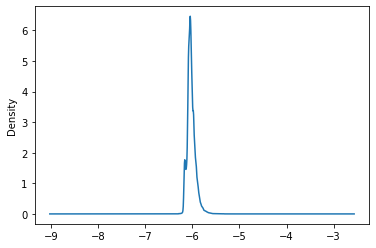

In [16]:
np.log10(sn38flux.head(int(1*len(sn38flux)))['flux']).plot(kind='kde')

<AxesSubplot:ylabel='Density'>

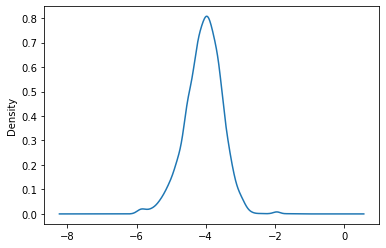

In [19]:
np.log10(dfsn38.head(int(1*len(dfsn38)))['Score']).plot(kind='kde')

In [15]:
dfsn38['Score']

0       0.000136
1       0.000155
2       0.000083
3       0.000247
4       0.000293
          ...   
5319    0.000106
5320    0.000043
5321    0.000091
5322    0.000093
5323    0.000289
Name: Score, Length: 5324, dtype: float64